In [15]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Steps along which the walk can step
STEPS = set([(1, 0), (0, 1), (-1, 0), (0, -1)])

# Colours for plots
RED = (1.00, 0.28, 0.18)
GREEN = (0.15, 0.64, 0.23)
GOLD = (1.00, 0.65, 0.06)
BLUE = (0.32, 0.57, 0.83)

def CartesianToLetter(Path: list[tuple]) -> str:
    ''' Convert a walk from Cartesian Coordinates to a more readable format (U,D,L,R) '''
    conversion = {(0,1):'U', (0,-1):'D', (-1,0):'L', (1,0):'R'}
    return "".join([conversion[(Path[i+1][0]-Path[i][0],Path[i+1][1]-Path[i][1])] for i in range(len(Path)-1)])

# Returns the coordinates of the neighbour to site given a direction to move 
GetNeighbour = lambda site, direction: tuple(x+y for x,y in zip(site, direction))


Configuration:
# of Steps: 150
# of Interactions: 58


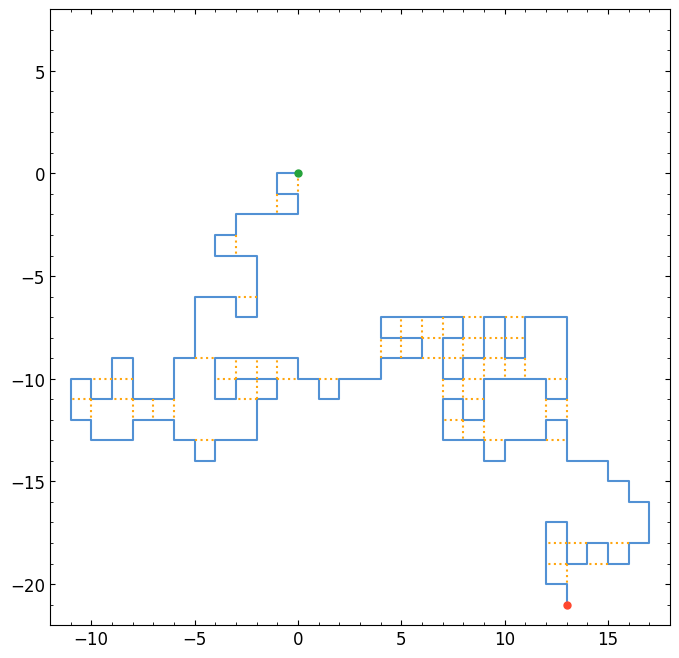

In [16]:
# Visualize interacting self-avoiding walks on a square lattice

max_size = 150

plt.figure(figsize=(8,8))

# Reset until a max_size configuration is found
n = 0
while n != max_size:
    site = (0,0)
    occupied_sites = [site]
    interactions = []
    n = m = 0
    a = 1
    while n < max_size:
        if a == 0:
            # Terminate early if there is no room to grow
            break
        # Create a list of all unvisited neighbours of the current site 
        unoccupied_sites = []
        for step in STEPS:
            new_site = GetNeighbour(site, step)
            if new_site not in occupied_sites:
                unoccupied_sites.append(new_site)
        # The atmosphere, a, is the number of unvisited neighbours of the current site
        a = len(unoccupied_sites)
        if a > 0:
            site = random.choice(unoccupied_sites)
            occupied_sites.append(site)
            n += 1
            # Iterate over the path taken upto the site 2 steps before the new site chosen at random
            # since at any step n, the earliest interaction possible would be at some site after n+3 steps
            for visited in occupied_sites[:-2]:
                # Check for adjacency between site and all other sites
                difference = (visited[0]-site[0], visited[1]-site[1])
                if (difference in STEPS):
                    interactions.append([visited, site])
                    m += 1

# Data about walk configuration
print('\nConfiguration:')
print(f'# of Steps: {n}')
print(f'# of Interactions: {m}')

# Plot the path of the walk
x = [v[0] for v in occupied_sites]
y = [v[1] for v in occupied_sites]
plt.plot(x,y, color=BLUE)

# Plot the interactions
for interaction in interactions:
    plt.plot([interaction[0][0], interaction[1][0]], [interaction[0][1], interaction[1][1]], ':', color=GOLD)

# Plot start and end points
plt.plot(0, 0, 'o', color=GREEN, markersize=5)
plt.plot(occupied_sites[-1][0], occupied_sites[-1][1], 'o', color=RED, markersize=5)

# Plot customization
# Create a bounding box to surround the walk adjusted to include some padding
pad = 1
# Get length of the longest axis spanned by the walk
dist_x = max(x)-min(x)
dist_y = max(y)-min(y)
longest_axis = max(dist_x, dist_y)
plt.axis([min(x)-pad, min(x)+longest_axis+pad, min(y)-pad, min(y)+longest_axis+pad])

plt.minorticks_on()
plt.tick_params(direction='in',which='both',left=True,right=True,bottom=True,top=True,labelsize=12)
plt.show()


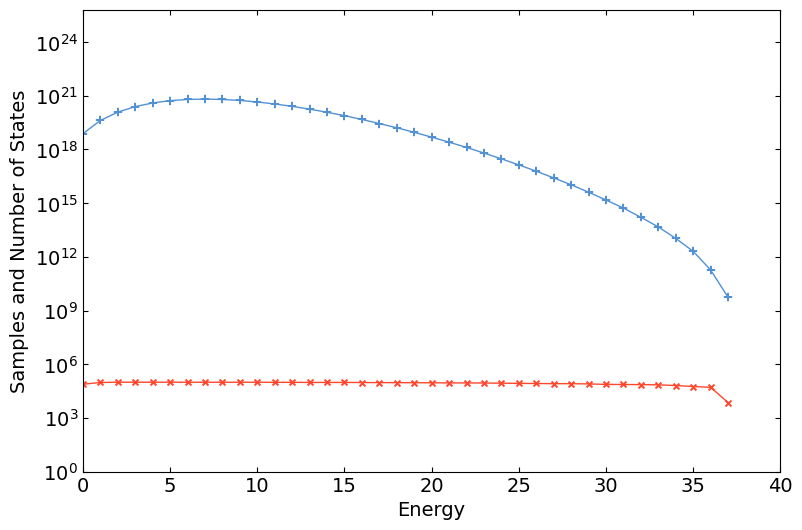

In [17]:
def flatperm_interacting_saw(max_size,max_tours):
    
    '''
    Produce a roughly uniform distribution of a two-dimensional self-avoiding walk based on
    the total size and number of tours of the walk using the Pruned and Enrichment Rosenbluth Method.
    
    Samples and weights are separated based on both length, in steps, and interactions; interactions
    occur when any non-consecutive sites of a walk are adjacent to each other.
   
    Parameters
    ----------
    max_size: maximum size, in steps, of the walk
    max_tours: total number of tours
    
    Returns
    -------    
    Two lists s,w where each entry s[n,m] represents the number of n-step walks explored with precisely
    m interactions, from n,m = 0 to n,m = max_size + 1 and each entry w[n,m] being the corresponding
    weights
    '''
    
    s = np.zeros((max_size+1, max_size+1))
    w = np.zeros((max_size+1, max_size+1))
    copy = np.zeros(max_size+1)
    weight = np.zeros(max_size+1)
    
    # Interactions[n] tells us at precisely what step an interaction occurs so when retracing steps
    # we know when to delete interactions.
    interactions = np.zeros(max_size+1)
    
    tours = n = m = 0 
    # Start new walk at origin and step size zero.
    a = copy[0] = weight[0] = 1
    s[0,0] += 1; w[0,0] += weight[0]
    site = (0,0)
    occupied_sites = [site] 
    while tours < max_tours:
        # If maximal length has been reached or the atmosphere is zero: Don't grow.
        if n == max_size or a == 0:
            copy[n] = 0
        else:
            # Pruning/enrichment by comparing the target weight with the averaged weight estimate.
            ratio = weight[n] / (w[n,m]/s[0,0])
            p, r = ratio % 1, random.random()
            # Generate a random number between 0 and 1
            if r < p:
                copy[n] = np.floor(ratio) + 1
            else:
                copy[n] = np.floor(ratio)
            weight[n] = w[n,m] / s[0,0]
        if copy[n] == 0:
            while n > 0 and copy[n] == 0:
                # Delete interactions before retracing a step since interactions are
                # recorded after each next step is taken.
                if interactions[n]:
                    m -= int(interactions[n])
                    interactions[n] = 0
                    
                # Delete last site of walk.
                occupied_sites = occupied_sites[:-1] 
                site = occupied_sites[-1]
                n -= 1
        if n == 0 and copy[0] == 0:
            # Start new tour.
            tours += 1
            # Start new walk with step size zero.
            a, copy[0] = 1, 1
            s[0,0] += 1; w[0,0] += weight[0]
            site = (0,0)
            occupied_sites = [site]
        else:
            unoccupied_sites = []
            # Create list of neighboring unoccupied sites, determine the atmosphere a.
            for step in STEPS:
                new_step = tuple(i+j for i,j in zip(site,step))
                if new_step not in occupied_sites:
                    unoccupied_sites.append(new_step)
            a = len(unoccupied_sites)
            # If the walk cannot continue, reject entire walk and exit loop.
            if a > 0:
                copy[n] -= 1
                # Draw one of the neighbouring unoccupied sites uniformly at random.
                # Step to new site.
                site = random.choice(unoccupied_sites)
                occupied_sites.append(site)
                n += 1
                # Check for interactions between new site and all other visited sites, ignore
                # the last 2 steps before new site.
                for visited in occupied_sites[:-2]:
                    # Check for adjacency between site and all other sites
                    difference = (visited[0]-site[0], visited[1]-site[1])
                    if difference in STEPS:
                        # If adjacent, it is an interaction
                        interactions[n] += 1
                        m += 1
                weight[n] = weight[n-1]*a
                s[n,m] += 1; w[n,m] += weight[n]
    s[0,0] -= 1; w[0,0] -= 1
    
    return s,w/s[0,0]

# Example
max_size, max_tours = 50, 1e5
s,w = flatperm_interacting_saw(max_size,max_tours)
plt.figure(figsize=(9,6))

# Extract the samples that generated max length walks with n interactions
# array[array != 0] discards the zero entries
mli = s[max_size,]
plt.plot(mli[mli != 0], 'x-', color=RED, lw=1, ms=1, mew=6)

# Estimate number of combinations 
estimated_counts = w[max_size,]
estimated_counts = estimated_counts[estimated_counts != 0]
plt.plot(estimated_counts, '+-', color=BLUE, lw=1, ms=1, mew=6)

# Plot customization
plt.yscale('log')
plt.xlabel('Energy',fontsize=14)
plt.ylabel('Samples and Number of States',fontsize=14)
plt.axis([0, max_size*0.8, 1, max(estimated_counts) * 1e5])
plt.tick_params(direction='in',left=True,right=True,bottom=True,top=True,labelsize=14)
plt.show()

In [19]:
exact_counts = np.zeros(max_size+1)
with open('interactive_saw_counts.ser', 'r') as f:
    f_content = [line.split() for line in f.readlines()]
    max_size_configs = []
    # Extrapolate all lines enumerating max_size step configurations
    max_size_configs = [line for line in f_content if line[1] == str(max_size)]
    # Clean up remaining lines by casting to ints 
    max_size_configs = [list(map(lambda x: int(x), line)) for line in max_size_configs] 
    # Assign the data given the extrapolated counts
    for line in max_size_configs:
        exact_counts[line[0]] = line[2]

# Remove trailing zeros
exact_counts = exact_counts[exact_counts != 0]

# Convert ratio to percentage and return as str (format to 2dp include trailing zeros)
ToPercent = lambda ratio : f'{(abs(1 - ratio) * 100):.2f}%'
ratios = estimated_counts/exact_counts

# Output the variance between the estimated counts and the exact counts
print(f'{max_size} Step Configurations')
print('\nVariance as ratios')
print(ratios)

print('\nVariance as percentages')
percentages = list(map(ToPercent, ratios))
line_length = 10
for x in range(0,len(percentages), line_length):
    print(', '.join(percentages[x:x+line_length]))

50 Step Configurations

Variance as ratios
[0.97646697 0.99096678 1.00455223 1.0106584  1.00636941 1.01148556
 1.00501118 1.0099884  1.00410246 1.00121974 1.00393438 0.99568862
 1.0052022  0.99922725 1.00218874 1.00857086 1.00337351 0.99440439
 1.00519032 1.00701188 1.00279028 1.00308063 1.01380057 0.99945992
 1.00177953 1.00143487 1.00289151 0.99785514 1.00803976 1.00022296
 0.99326204 1.02653259 0.99134321 1.02470785 0.96814316 0.99883885
 0.93966529 1.08295718]

Variance as percentages
2.35%, 0.90%, 0.46%, 1.07%, 0.64%, 1.15%, 0.50%, 1.00%, 0.41%, 0.12%
0.39%, 0.43%, 0.52%, 0.08%, 0.22%, 0.86%, 0.34%, 0.56%, 0.52%, 0.70%
0.28%, 0.31%, 1.38%, 0.05%, 0.18%, 0.14%, 0.29%, 0.21%, 0.80%, 0.02%
0.67%, 2.65%, 0.87%, 2.47%, 3.19%, 0.12%, 6.03%, 8.30%
